#Khai báo thư viện

In [ ]:
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize

#Tiền xử lí dữ liệu


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')

with open('vietnamcorpus.txt', 'r', encoding='utf-8') as file:
    corpus = file.read()

# Chuyển tất cả văn bản thành chữ thường
corpus = corpus.lower()

# Loại bỏ dấu câu và ký tự đặc biệt
corpus = re.sub(r'[^\w\s]', '', corpus)

# Tách từ
tokens = word_tokenize(corpus)

# Tạo từ điển từ vựng
vocabulary = list(set(tokens))  # Loại bỏ các từ trùng lặp
word_to_index = {word: index for index, word in enumerate(vocabulary)}
index_to_word = {index: word for word, index in word_to_index.items()}

# In ra một vài kết quả để kiểm tra
print("Vocabulary:", vocabulary[:10])
print("Word to Index:", dict(list(word_to_index.items())[:10]))
print("Index to Word:", dict(list(index_to_word.items())[:10]))

Vocabulary: ['nền', 'dành', 'liêm', 'truyền', 'thương', 'tuyệt', 'giá', 'tính', 'liệu', 'tú']
Word to Index: {'nền': 0, 'dành': 1, 'liêm': 2, 'truyền': 3, 'thương': 4, 'tuyệt': 5, 'giá': 6, 'tính': 7, 'liệu': 8, 'tú': 9}
Index to Word: {0: 'nền', 1: 'dành', 2: 'liêm', 3: 'truyền', 4: 'thương', 5: 'tuyệt', 6: 'giá', 7: 'tính', 8: 'liệu', 9: 'tú'}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#Tạo dữ liệu huấn luyện

In [ ]:
import random

def generate_training_data(tokens, window_size):
    training_data = []
    for i in range(window_size, len(tokens) - window_size):
        center_word = tokens[i]
        context_words = tokens[i - window_size:i] + tokens[i + 1:i + window_size + 1]

        for context_word in context_words:
            training_data.append((center_word, context_word))

    return training_data

# Thiết lập kích thước cửa sổ ngữ cảnh
window_size = 2

# Tạo training_data từ tokens
training_data = generate_training_data(tokens, window_size)

# Chuyển đổi từ thành chỉ số trong từ điển
training_data_indices = [(word_to_index[center_word], word_to_index[context_word])
                         for center_word, context_word in training_data]

# In một vài cặp trung tâm-ngữ cảnh để kiểm tra
print(training_data_indices[:10])

# Tạo từ điển ánh xạ chỉ số về từ
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Tra cứu một vài chỉ số thành từ tương ứng
for center_idx, context_idx in training_data_indices[:10]:
    print(f"Center Word: {index_to_word[center_idx]}, Context Word: {index_to_word[context_idx]}")



[(348, 169), (348, 468), (348, 231), (348, 283), (231, 468), (231, 348), (231, 283), (231, 320), (283, 348), (283, 231)]
Center Word: huang, Context Word: ông
Center Word: huang, Context Word: jensen
Center Word: huang, Context Word: nói
Center Word: huang, Context Word: nvidia
Center Word: nói, Context Word: jensen
Center Word: nói, Context Word: huang
Center Word: nói, Context Word: nvidia
Center Word: nói, Context Word: mua
Center Word: nvidia, Context Word: huang
Center Word: nvidia, Context Word: nói


#Mô hình SkipGram

In [ ]:
class SkipGram:
    def __init__(self, vocabulary_size, embedding_dim, learning_rate=0.01):
        self.vocabulary_size = vocabulary_size
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate

        # Ma trận nhúng W1 (vocabulary_size x embedding_dim)
        self.W1 = np.random.randn(self.vocabulary_size, self.embedding_dim)

        # Ma trận đầu ra W2 (embedding_dim x vocabulary_size)
        self.W2 = np.random.randn(self.embedding_dim, self.vocabulary_size)

    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def cross_entropy_loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred))

    def forward(self, center_word_idx, context_word_idx):
        # Lấy vector nhúng cho từ trung tâm từ W1
        center_word_vector = self.W1[center_word_idx]

        # Dự đoán vector cho ngữ cảnh
        output = np.dot(center_word_vector, self.W2)

        # Áp dụng softmax để tính xác suất cho mỗi từ ngữ cảnh
        output = self.softmax(output)

        # Tạo one-hot vector cho từ ngữ cảnh
        target = np.zeros(self.vocabulary_size)
        target[context_word_idx] = 1

        # Tính hàm mất mát
        loss = self.cross_entropy_loss(target, output)

        return loss, output

    def backward(self, center_word_idx, context_word_idx, output):
        # Tính gradient đối với W2
        target = np.zeros(self.vocabulary_size)
        target[context_word_idx] = 1
        dW2 = np.outer(self.W1[center_word_idx], output - target)

        # Tính gradient đối với W1
        dW1 = np.dot(self.W2, output - target)

        return dW1, dW2

    def update_weights(self, dW1, dW2):
        # Cập nhật trọng số W1 và W2 theo gradient descent
        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2


#Huấn luyện mô hình

Epoch 1/10, Loss: 249315.82270392202
Epoch 2/10, Loss: 183279.93519262396
Epoch 3/10, Loss: 149919.11782099312
Epoch 4/10, Loss: 128320.63745566206
Epoch 5/10, Loss: 112850.68159554474
Epoch 6/10, Loss: 101309.17457503497
Epoch 7/10, Loss: 92298.85461174595
Epoch 8/10, Loss: 84991.15366778008
Epoch 9/10, Loss: 78946.78579637785
Epoch 10/10, Loss: 73891.82927887805


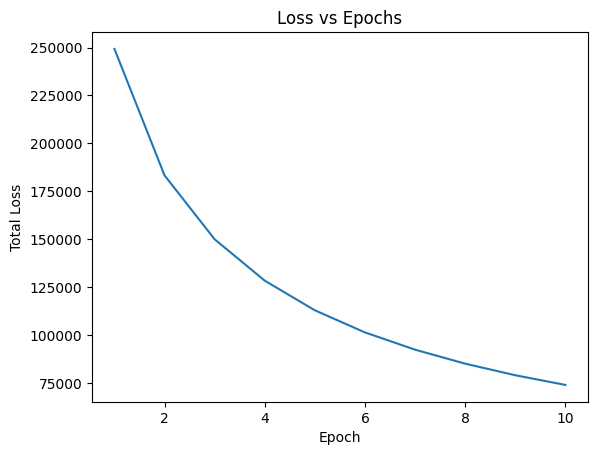

In [ ]:
import matplotlib.pyplot as plt

embedding_dim = 100
epochs = 10
learning_rate = 0.01
batch_size = 1
# Tạo đối tượng mô hình
model = SkipGram(vocabulary_size=len(vocabulary), embedding_dim=embedding_dim, learning_rate=learning_rate)

# Khởi tạo danh sách lưu trữ giá trị mất mát mỗi epoch
losses = []

# Huấn luyện mô hình
for epoch in range(epochs):
    total_loss = 0
    for center_word_idx, context_word_idx in training_data_indices:
        loss, output = model.forward(center_word_idx, context_word_idx)
        total_loss += loss

        # Lan truyền ngược
        dW1, dW2 = model.backward(center_word_idx, context_word_idx, output)

        # Cập nhật trọng số
        model.update_weights(dW1, dW2)

    losses.append(total_loss)  # Lưu tổng mất mát của epoch

    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss}')

# Vẽ biểu đồ mất mát theo epoch
plt.plot(range(1, epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss vs Epochs')
plt.show()


#Embedding Vector

In [ ]:
from scipy.spatial.distance import cosine

def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

# Ví dụ đánh giá tương đồng giữa các từ
word1_idx = word_to_index['mua']
word2_idx = word_to_index['sắm']

# Ví dụ đánh giá đối lập giữa các từ
word3_idx = word_to_index['mua']
word4_idx = word_to_index['bán']


# Ví dụ đánh giá thông thường giữa các từ
word5_idx = word_to_index['mua']
word6_idx = word_to_index['xây']

similarity = cosine_similarity(model.W1[word1_idx], model.W1[word2_idx])
print(f"Cosine similarity between 'mua' and 'sắm': {similarity}")


similarity = cosine_similarity(model.W1[word3_idx], model.W1[word4_idx])
print(f"Cosine similarity between 'mua' and 'bán': {similarity}")


similarity = cosine_similarity(model.W1[word5_idx], model.W1[word6_idx])
print(f"Cosine similarity between 'mua' and 'xây': {similarity}")



Cosine similarity between 'mua' and 'sắm': 0.39516576845602813
Cosine similarity between 'mua' and 'bán': 0.22240137245069247
Cosine similarity between 'mua' and 'xây': 0.2838234007314203
